<a id="section_toc"></a> 

# Tabla de Contenidos

[0 - Imports y definiciones](#section_imports) <br>
[1 - Primer análisis del DataFrame y limpieza](#section_analisis) <br>
[2 - Modelado](#section_modelado) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 - MultinomialNB](#section_MultinomialNB) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 - CatBoostClassifier](#section_CatBoostClassifier) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 - RandomForestClassifier](#section_RandomForestClassifier) <br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 - MultinomialNB con otro subreddit](#section_MultinomialNB_2) <br>


<a id="section_imports"></a> 

## 0 - Imports y definiciones

[volver a TOC](#section_toc)

In [151]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import re

from catboost import CatBoostClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from multiprocessing import Pool
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

import unidecode

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [99]:
# Esta función samplea estratificadamente, algo que el método pd.DataFrame.sample no soporta.
# Ojo que retorna nrows = n_samples * n_categorias, en nuestro caso, n_samples * 39

def stratified_sample_df(df, col, n_samples, random_state= None):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state= random_state))
    df_.index = df_.index.droplevel(0)
    return df_


def binary_sample(df, col, value, samples= None, random_state= None):
    """
    El df que retorna no esta shuffleado: las primeras n = n_samples filas co-
    rresponden a la clase que queremos true. Se puede lograr haciendo
    df.sample(frac= 1) pero no sé en este momento si hace falta o no, entonces
    no me caliento al respecto. No samplea estratificado porque---en nuestro
    caso al menos---para que quede balanceado tengo que tener
    `n_samples` % 39 == 0... en otras palabras, para que sea estratificado ne-
    cesariamente tengo que tomar una fila de cada clase (de las falsas), que
    son justamente 39. Tons hago un sampleo común y fue.
    Lo perfecto senemigo de lo bueno.
    
    Parametros
    ----------
    
    df : pd.DataFrame
    \tEl df del que vamos a samplear
    
    col : str
    \tLa columna target que queremos samplear
    
    value : str
    \tLa categoría que queremos clasificar como True. Si no está en df[col].unique()
    \traisea warning y retorna None
    
    samples : int, default None
    \tLa cantidad de muestras que quiero. El df final tendrá `samples` * 2 filas
    \tSi es None, `samples` es igual a la cantidad de filas de `value`
    \tSi es mayor a la cantidad de filas de `value`, raisea warning y se fija
    \tigual que en el caso `samples` = None
    
    random_state : int y otros, default 1
    \tPara reproducibilidad. Los otros tipos soportados pueden consultarse en la
    \tdocumentación de pd.DataFrame.sample
    """ 
    import warnings
    
    if value in df[col].unique():
 
        mask = df[col] == value
        mask_index = df[mask].index

        df_pos = df[mask].copy(deep= True)
        df_neg = df.drop(index= mask_index, inplace= False)
        
        max_samples = df_pos.shape[0]

        if samples == None:
            samples = max_samples

        elif samples > max_samples:
            warnings.warn(f'\nCannot take a larger sample than population. Samples was {samples} but is now set to {max_samples}')

        n = min(samples, max_samples)

        df_pos = df_pos.sample(n= n, random_state= random_state)
        df_neg = df_neg.sample(n= n, random_state= random_state)

        df_ = pd.concat([df_pos, df_neg]).reset_index(drop= True)
        
        return df_
    
    else:
        warnings.warn(f'\nValue {value} not in column {col}. No operation performed.')
        return None    

    
def tokenize(x, stopwords):
    tokens = word_tokenize(x)
    tokens_without_stopwords = [tok for tok in tokens if not (tok in stopwords)]
    string = ' '.join(tokens_without_stopwords)
    
    return string


# Matriz de confusión con los yticks centrados
def conf_mat(y_test, Y_pred, umbral=0.5):

    conf_mat = confusion_matrix(y_test, Y_pred)
    conf_mat_df = pd.DataFrame(data=conf_mat, 
                               index=['Actual Negative: 0', 'Actual Positive: 1'], 
                               columns=['Predict Negative: 0', 'Predict Positive: 1'])

    fig, ax = plt.subplots()
    ax = sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='YlGnBu', ax= ax)
    ax.set_title(f'Matriz de confusión. Umbral = {umbral}')
    ax.set_yticklabels(list(conf_mat_df.index), rotation=90, va="center");

<a id="section_analisis"></a>

## 1 - Primer análisis del DataFrame y limpieza

[volver a TOC](#section_toc)

Reddit, según wikipedia es "un sitio web de marcadores sociales y agregador de noticias donde los usuarios pueden añadir textos, imágenes, videos o enlaces. Los usuarios pueden votar a favor o en contra del contenido, haciendo que aparezcan en las publicaciones destacadas."

Podríamos describirlo en palabras más sencillas como un foro. Cada subforo se llama <em>subreddit</em>, y tratan tópicos muy diversos.

Este dataframe contiene un millón de comentarios de reddit, los cuales fueron tomados de manera uniforme de los 40 subreddits más populares en mayo del 2019; es decir tenemos 25 k comentarios por subreddit. Esto nos va a ser útil ya que vamos a partir de un set balanceado. Además ya está preprocesado: se han quitado los comentarios eliminados y aquellos que tengan menos de cuatro <em>tokens</em>, i.e. que sean demasiado cortos.

Las columnas son:

* <b>subreddit:</b> de qué subforo fue tomado el comentario,
* <b>body:</b> el cuerpo del comentario,
* <b>controversiality:</b> una métrica propia de reddit; son booleanos,
* <b>score:</b> un puntaje calculado como upvotes - downvotes.

Con esta base podemos realizar un modelo de clasificación en el que podamos predecir a qué subreddit pertenece un comentario.
Con la cantidad de features que tenemos podemos correr modelos, pero también hay lugar a generar más features.

In [3]:
data_path = "../data/kaggle_RC_2019-05.csv"

data = pd.read_csv(data_path, encoding= 'utf-8')

In [4]:
nrow, ncol = data.shape

data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB


In [5]:
data.sample(5)

,subreddit,body,controversiality,score
343646,worldnews,Not really. Assuming the tank is made of some ...,1,0
876456,MortalKombat,"Reptile, Cyrax, Sektor, Smoke, Ermac, DOOM Slayer",0,0
926198,todayilearned,I've spelt it out quite succinctly. Your... at...,0,1
831701,RoastMe,Damn man leave some of the roasting for us. Yo...,0,1
225102,relationship_advice,"Respect yourself, no excuse for this kind of b...",0,2


Vimos que algunos comentarios no estaban en inglés, vamos a chequear que hay en cada subreddit. Para esto usamos un sampleo estratificado y tomamos un comentario de cada subreddit.

In [6]:
# Esto está para ver un comentario de cada subreddit para ver si están todos en inglés
# Spoiler alert: hay uno ruso.

data_aux = stratified_sample_df(data, 'subreddit', 1, random_state= 10)

for body, subreddit in zip(data_aux['body'], data_aux['subreddit']):
    print(subreddit)
    print(body)
    print('\u2014' * 80)

AmItheAsshole
Do you understand how ridiculous that sounds lol you literally just said the same thing
————————————————————————————————————————————————————————————————————————————————
Animemes
The virgin r/waterbros

The chad r/hydrohomies
————————————————————————————————————————————————————————————————————————————————
AskReddit
Chopping firewood. Feels good to hit shit and see it split.
————————————————————————————————————————————————————————————————————————————————
ChapoTrapHouse
folks folks ive been a bottom my whole life, but now i think that its about time for trump to switch things up what do you think about that folks

who wants to see trump on top folks?
————————————————————————————————————————————————————————————————————————————————
FortNiteBR
**Unfortunately, we've had to remove your post.**
___


### Post Flair Guidelines

We require all users to set a post flair for their own post. There is a 30 minute grace period, and this has passed for this post. 

Don't know how to flai

In [7]:
mask_pikabu = data['subreddit'] == 'Pikabu'
pikabu_index = data[mask_pikabu].index

data.iloc[pikabu_index, 0].value_counts()  # Chequeamos que hayamos capturado lo que queríamos

Pikabu    25000
Name: subreddit, dtype: int64

In [8]:
data = data.drop(index= pikabu_index).reset_index(drop= True)

Vimos que algunos comentarios comienzan con `&gt;`, que es un <em>entity name</em> de html para el caracter `>`. Dentro del contexto de foros y message boards este símbolo se usa al comienzo de una línea de texto para indicar que ésta es una cita a otro comentario. Creemos que es accidental que ese grupo de caracteres haya llegado al dataset, no obstante vamos a aprovecharlo para crear una nueva feature. Aparte, vamos a usar regex para limpiar todos los saltos de línea que no fueron codificados correctamente (se muestra el comando unicode `\n`)

In [9]:
# Creamos una feature dummy que indica si el comentario incluye una cita/respuesta a otro.

pattern_html_gt = r'&gt;'
rx_html_gt = re.compile(pattern= pattern_html_gt, flags= re.IGNORECASE)

data['is_reply'] = 0

mask_reply = data['body'].apply(rx_html_gt.search).apply(bool)

data.loc[mask_reply, 'is_reply'] = 1

In [10]:
# Creamos una copia de la columna `body` para limpiarla, conservando la original.

data['body_clean'] = data['body'].copy(deep= True)

In [11]:
pattern_unicode_space = r'[\t\n\r\f\v(\xa0)]'  # Espacios unicode (tab, newline, nonbreaking, vtab, lf, cr)
rx_unicode_space = re.compile(pattern= pattern_unicode_space, flags= re.IGNORECASE)

pattern_url = r"http\S+"  # URLs, aunque hay que tener cuidado ya que tiene que haber un espacio al final de la url, sino captura texto también.
rx_url = re.compile(pattern= pattern_url, flags= re.ASCII)

pattern_html_symbol = r'&\w+;'  # Símbolos que están en formato html &..;
rx_html_symbol = re.compile(pattern= pattern_html_symbol, flags= re.ASCII)

pattern_punkt = r'([^\s\w]|_)+'  # Signos de puntuación
rx_punkt = re.compile(pattern= pattern_punkt, flags= re.IGNORECASE)

data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_unicode_space, ' ', x))  # Reemplazamos espacios unicode por ' '
data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_url, '', x))  # Quitamos URLs
data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_html_symbol, ' ', x))  # Quitamos símbolos HTML &..;
data['body_clean'] = data['body_clean'].apply(lambda x: re.sub(rx_punkt, ' ', x))  # Quitamos puntuación
data['body_clean'] = data['body_clean'].apply(lambda x: unidecode.unidecode(x.lower()))  # Quitamos tildes y pasamos a minusculas

In [12]:
# Tarda de 5' a 15' en tokenizar todo

data['tokens'] = data['body_clean'].apply(lambda x : tokenize(x, stopwords_en))

In [13]:
# Creamos una feature: largo del comentario (sólo contando tokens)

data['body_len'] = data['tokens'].apply(lambda x : len(x.split()))

In [14]:
data.sample(10)

,subreddit,body,controversiality,score,is_reply,body_clean,tokens,body_len
502632,nfl,I really don’t think this is the insult to the...,0,4,0,i really don t think this is the insult to the...,really think insult broncos everyone taking,6
756529,news,I want to be successful and raise a yacht! I w...,0,2,0,i want to be successful and raise a yacht i w...,want successful raise yacht would coolest kid ...,10
230394,asoiaf,Yep. I don't see how I could bother being inte...,0,0,0,yep i don t see how i could bother being inte...,yep see could bother interested bran 8000 year...,26
431971,soccer,Did they even really check?\nThey were kinda b...,0,1,0,did they even really check they were kinda bu...,even really check kinda busy treating wound we...,17
467709,FortNiteBR,We asked ourselves the same question lol,0,2,0,we asked ourselves the same question lol,asked question lol,3
963430,trashy,go back to r/chapobraphouse,0,16,0,go back to r chapobraphouse,go back r chapobraphouse,4
579032,hockey,Holy fuck that made me angry,0,1,0,holy fuck that made me angry,holy fuck made angry,4
872392,nfl,Oh shit you’re right!,0,4,0,oh shit you re right,oh shit right,3
945033,trashy,Can't live without my Taco Bell .,0,1,0,can t live without my taco bell,live without taco bell,4
804848,Animemes,for me it sounds like a brand one of my fav yo...,0,1,0,for me it sounds like a brand one of my fav yo...,sounds like brand one fav youtubers constantly...,8


In [58]:
data.to_pickle('datos_limpios.pickle')

In [ ]:
data = pd.read_pickle('datos_limpios.pickle')

In [171]:
data_q90 = data[data['body_len'] < data['body_len'].quantile(0.90)]

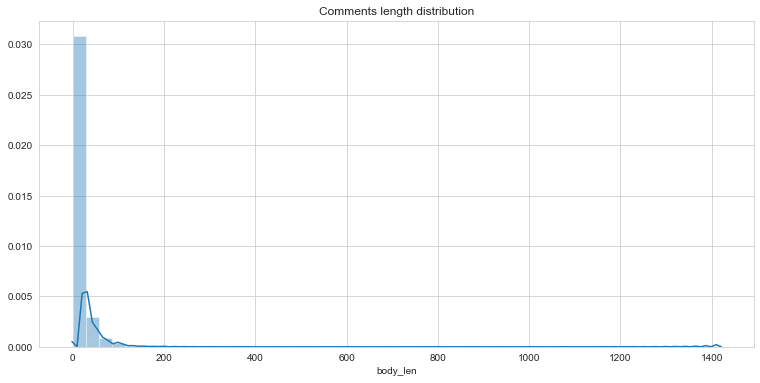

In [199]:
plt.figure(figsize=(12.8,6))
sns.distplot(data['body_len']).set_title('Comments length distribution');

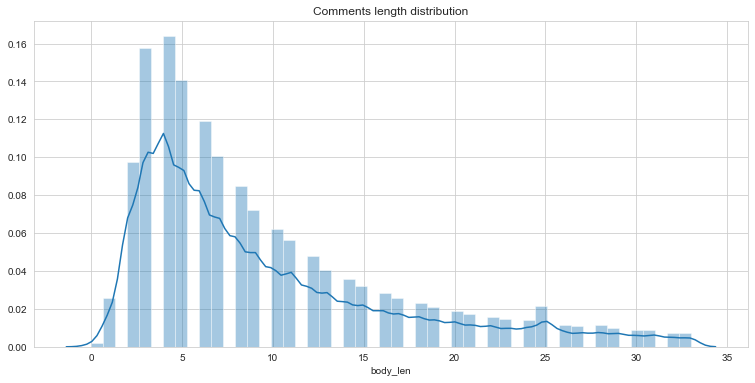

In [172]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_q90['body_len']).set_title('Comments length distribution');

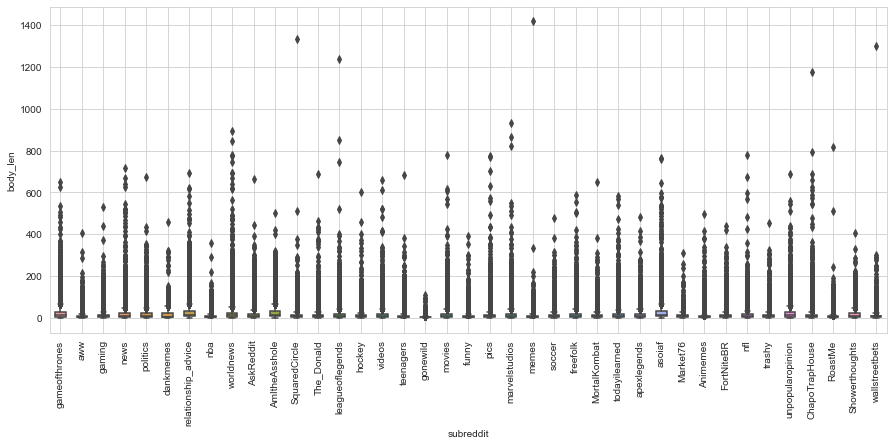

In [174]:
# No nos sirve ver el dataset entero, vamos a mirar el 90% inferior
plt.figure(figsize=(15,6))
sns.boxplot(data=data, x='subreddit', y='body_len', width=0.5, orient= "v");
plt.xticks(rotation=90)
plt.grid(True)

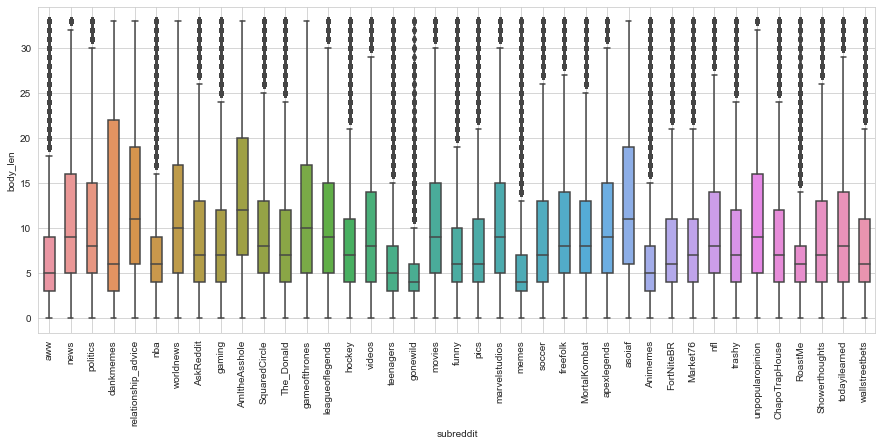

In [173]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data_q90, x='subreddit', y='body_len', width=0.5, orient= "v");
plt.xticks(rotation=90)
plt.grid(True)

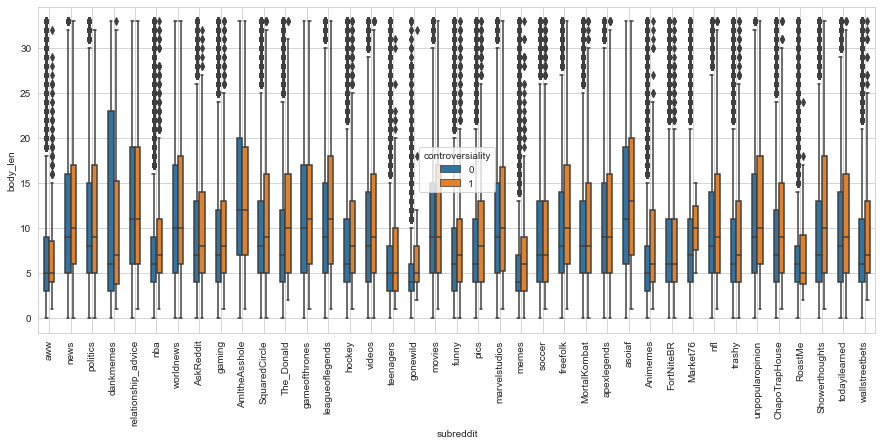

In [176]:
# Buscamos ver si hay alguna relacion en la longitud de los comentarios y la controversialidad

plt.figure(figsize=(15,6))
sns.boxplot(data=data_q90, x='subreddit', y='body_len', width=0.5, orient= "v", hue= "controversiality");
plt.xticks(rotation=90)
plt.grid(True)

<a id="section_modelado"></a>

## 2 - Modelado

[volver a TOC](#section_toc)

Como el modelo que queremos crear es muy intenso en recursos (1 M filas, 39 categorías), vamos a clasificar binariamente si un comentario pertenece o no a un subreddit. Para esto vamos a elegir un subreddit y samplear 25 k comentarios de los otros 38. Sobre esta base vamos a correr todos los modelos. Sobre el final, vamos a probar el mismo modelo pero con otro subreddit a ver qué ocurre.

In [155]:
data_sample = binary_sample(data, 'subreddit', 'Market76', random_state=42)
data_sample['class'] = 0
mask = data_sample['subreddit'] == 'Market76'
data_sample.loc[mask, 'class'] = 1

In [23]:
data_sample.sample(5)

,subreddit,body,controversiality,score,is_reply,body_clean,tokens,body_len,class
3343,videos,Giving homes to addicts and the mentally ill i...,0,7,0,giving homes to addicts and the mentally ill i...,giving homes addicts mentally ill solution was...,141,0
770,Market76,"Its okay tbh, just cool to have cuz legacy now",0,2,0,its okay tbh just cool to have cuz legacy now,okay tbh cool cuz legacy,5,1
3984,marvelstudios,This weekend will be interesting to see how mu...,0,2,0,this weekend will be interesting to see how mu...,weekend interesting see much get much drop,7,0
2090,memes,"Hey there, friendo u/moistest-boi! Thanks for ...",0,1,0,hey there friendo u moistest boi thanks for ...,hey friendo u moistest boi thanks submitting r...,51,0
930,Market76,**Trader**|**+Karma**|**Cake Day**|**Submissio...,0,1,0,trader karma cake day submission karma u m...,trader karma cake day submission karma u mindc...,71,1


Aquí separamos en train y test, usamos como predictora el cuerpo crudo de los mensajes. Por razones de tiempo no llegamos a probar modelos con la versión tokenizada por `nltk` para estudiar diferencias entre el preprocesado de `sklearn` que incluímos en el pipeline y el que hicimos antes. Igualmente sirvió como entrenamiento para usar la herramienta `nltk`

In [156]:
X = data_sample["body"]
y = data_sample["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500,)
(12500,)
(37500,)
(12500,)


<a id="section_MultinomialNB"></a>

### 2.1 - MultinomialNB

[volver a TOC](#section_toc)

In [29]:
# Esta instancia de pipeline será usada a lo largo de los modelos.

pipe_1_steps = [('preprocesamiento', TfidfVectorizer()),
                ('clf', MultinomialNB())]

pipe_1 = Pipeline(pipe_1_steps)

In [61]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_1 = {'preprocesamiento' : [TfidfVectorizer(), CountVectorizer()],
                'preprocesamiento__stop_words': ['None', 'english'],  #con o sin stopwords
                'preprocesamiento__max_df': np.logspace(-2, 0, num= 10),  #elimina términos con frecuencia mayor al valor dado
                'preprocesamiento__min_df': np.logspace(-12, -10, num= 10), #elimina términos con frecuencia menor al valor dado
                'preprocesamiento__ngram_range': [(1,1),(1,2)], #genera n-gramas
                }

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv= folds, verbose= 10, scoring= 'accuracy', n_jobs= -1)

In [62]:
# Aprox 30' sobre 2400 fits (3 folds, 800 combinaciones de hiperparámetros)
grid_1.fit(X_train, y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1756s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (4.4519s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  1.6min
[Parallel(n_jo

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'preprocesamiento': [TfidfVectorizer(max_df=0.0774263682681127,
                                                               min_df=1e-12,
                                                               ngram_range=(1,
                                                                            2),
                                                               stop_words='english'),
                                               CountVectorizer()],
                          'preprocesamiento__max_df': ar...
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                          'preprocesamiento__min_df': array([1.00000000e-12, 1.66810054e-12, 2.78255940e-12, 4.64158883e-12,
       7.74263683e-1

In [64]:
modelo1_filename = 'multinomialNB_25k.pickle'
pickle.dump(grid_1, open(modelo1_filename, 'wb'))

In [56]:
grid_1 = pickle.load(open('modelo1.pickle', 'rb'))

{'preprocesamiento': TfidfVectorizer(max_df=0.23, min_df=1e-10, stop_words='english'), 'preprocesamiento__max_df': 0.23, 'preprocesamiento__min_df': 1e-10, 'preprocesamiento__ngram_range': (1, 1), 'preprocesamiento__stop_words': 'english'}
0.9086666666666666


In [153]:
print(grid_1.best_params_)
print(grid_1.best_score_)

{'preprocesamiento': TfidfVectorizer(max_df=0.0774263682681127, min_df=1e-12, ngram_range=(1, 2),
                stop_words='english'), 'preprocesamiento__max_df': 0.0774263682681127, 'preprocesamiento__min_df': 1e-12, 'preprocesamiento__ngram_range': (1, 2), 'preprocesamiento__stop_words': 'english'}
0.9337866666666667


In [157]:
y_pred = grid_1.predict(X_test)
accuracy_score(y_test, y_pred)

0.93888

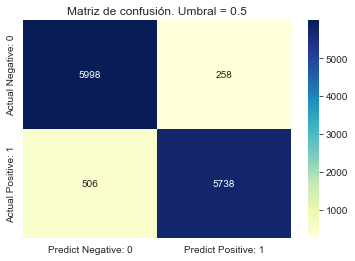

In [132]:
conf_mat(y_test, y_pred)

In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      6256
           1       0.96      0.92      0.94      6244

    accuracy                           0.94     12500
   macro avg       0.94      0.94      0.94     12500
weighted avg       0.94      0.94      0.94     12500



In [57]:
# Guardamos esto para más adelante
best_params_grid_1 = modelo1.best_params_

<a id="section_CatBoostClassifier"></a>

### 2.2 - CatBoostClassifier

[volver a TOC](#section_toc)

In [70]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_2 = {
     'preprocesamiento__stop_words': [best_params_grid_1['preprocesamiento__stop_words']], 
     'preprocesamiento__max_df': [best_params_grid_1['preprocesamiento__max_df']],  
     'preprocesamiento__min_df': [best_params_grid_1['preprocesamiento__min_df']], 
     'preprocesamiento__ngram_range': [best_params_grid_1['preprocesamiento__ngram_range']],
     'clf': [CatBoostClassifier()],
     'clf__task_type': ['CPU'],
     'clf__boosting_type': ['Plain'],
     'clf__max_ctr_complexity': [1],
     'clf__gpu_cat_features_storage': ['CpuPinnedMemory']
    }

grid_2 = GridSearchCV(pipe_1, param_grid_2, cv=folds, verbose=10, scoring='accuracy', n_jobs=-1)

In [70]:
# Alrededor de 25' con 3 fits (3 folds, 1 set de hiperparámetros)
grid_2.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 16.2min finished


Learning rate set to 0.048422
0:	learn: 0.6644868	total: 665ms	remaining: 11m 4s
1:	learn: 0.6435499	total: 1.22s	remaining: 10m 9s
2:	learn: 0.6173480	total: 1.79s	remaining: 9m 55s
3:	learn: 0.6018848	total: 2.29s	remaining: 9m 30s
4:	learn: 0.5831451	total: 2.76s	remaining: 9m 10s
5:	learn: 0.5692502	total: 3.26s	remaining: 8m 59s
6:	learn: 0.5616214	total: 3.74s	remaining: 8m 50s
7:	learn: 0.5524842	total: 4.22s	remaining: 8m 43s
8:	learn: 0.5452675	total: 4.79s	remaining: 8m 47s
9:	learn: 0.5356800	total: 5.34s	remaining: 8m 49s
10:	learn: 0.5302415	total: 5.84s	remaining: 8m 45s
11:	learn: 0.5247182	total: 6.35s	remaining: 8m 43s
12:	learn: 0.5200791	total: 6.86s	remaining: 8m 40s
13:	learn: 0.5151569	total: 7.32s	remaining: 8m 35s
14:	learn: 0.5093951	total: 7.79s	remaining: 8m 31s
15:	learn: 0.5049541	total: 8.26s	remaining: 8m 28s
16:	learn: 0.5004500	total: 8.76s	remaining: 8m 26s
17:	learn: 0.4963288	total: 9.3s	remaining: 8m 27s
18:	learn: 0.4932507	total: 9.86s	remaining: 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf': [<catboost.core.CatBoostClassifier object at 0x000002A4B1236648>],
                         'clf__boosting_type': ['Plain'],
                         'clf__gpu_cat_features_storage': ['CpuPinnedMemory'],
                         'clf__max_ctr_complexity': [1],
                         'clf__task_type': ['CPU'],
                         'preprocesamiento__max_df': [0.23],
                         'preprocesamiento__min_df': [1e-10],
                         'preprocesamiento__ngram_range': [(1, 1)],
                         'preprocesamiento__stop_words': ['english']},
             scoring='accuracy', verbose=10)

In [85]:
modelo2_filename = 'CBClassifier_25k.pickle'
pickle.dump(grid_2, open(modelo2_filename, 'wb'))

In [86]:
grid_2 = pickle.load(open('CBClassifier_25k.pickle', 'rb'))

{'clf': <catboost.core.CatBoostClassifier object at 0x000002A4846D3E08>, 'clf__boosting_type': 'Plain', 'clf__gpu_cat_features_storage': 'CpuPinnedMemory', 'clf__max_ctr_complexity': 1, 'clf__task_type': 'CPU', 'preprocesamiento__max_df': 0.23, 'preprocesamiento__min_df': 1e-10, 'preprocesamiento__ngram_range': (1, 1), 'preprocesamiento__stop_words': 'english'}
0.9119999999999999


In [83]:
print(grid_2.best_params_)
print(grid_2.best_score_)

{'clf': <catboost.core.CatBoostClassifier object at 0x000002A4B1236648>, 'clf__boosting_type': 'Plain', 'clf__gpu_cat_features_storage': 'CpuPinnedMemory', 'clf__max_ctr_complexity': 1, 'clf__task_type': 'CPU', 'preprocesamiento__max_df': 0.23, 'preprocesamiento__min_df': 1e-10, 'preprocesamiento__ngram_range': (1, 1), 'preprocesamiento__stop_words': 'english'}
0.9119999999999999


In [160]:
y_pred = grid_2.predict(X_test)
accuracy_score(y_test, y_pred)

0.91688

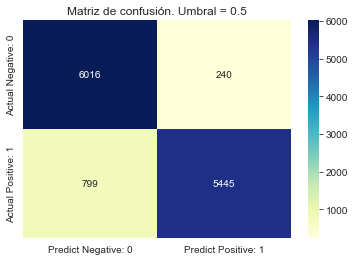

In [134]:
conf_mat(y_test, y_pred)

In [161]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      6256
           1       0.96      0.87      0.91      6244

    accuracy                           0.92     12500
   macro avg       0.92      0.92      0.92     12500
weighted avg       0.92      0.92      0.92     12500



<a id="section_RandomForestClassifier"></a>

### 2.3 - RandomForestClassifier

[volver a TOC](#section_toc)

In [93]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_3 = {'preprocesamiento' : [TfidfVectorizer(), CountVectorizer()],
                 'preprocesamiento__stop_words': ['None', 'english'],  #con o sin stopwords
                 'preprocesamiento__max_df': np.logspace(-2, 0, num= 5),  #elimina términos con frecuencia mayor al valor dado
                 'preprocesamiento__min_df': np.logspace(-11, -8, num= 5), #elimina términos con frecuencia menor al valor dado
                 'preprocesamiento__ngram_range': [(1,1),(1,2)], #genera n-gramas
                 'clf': [RandomForestClassifier()],
                 'clf__max_depth': [3, 4, 5]  # Sin limitar el numero de árboles tardaba días en correr
                }


grid_3 = GridSearchCV(pipe_1, param_grid_3, cv=folds, verbose=10, scoring='accuracy', n_jobs=-1)

In [93]:
# Aprox 30' para 1800 fits (3 folds, 600 combinaciones de hiperparámetros)
grid_3.fit(X_train, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf': [RandomForestClassifier(max_depth=5)],
                         'clf__max_depth': [3, 4, 5],
                         'preprocesamiento': [TfidfVectorizer(max_df=0.03162277660168379,
                                                              min_df=1e-08,
                                                              stop_words='english'),
                                              CountVectorizer()],
                         'preprocesamiento__max_df': array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ]),
                         'preprocesamiento__min_df': array([1.00000000e-11, 5.62341325e-11, 3.16227766e-10, 1.77827941e-09,
       1.00000000e-08]),
                         'preprocesamien

In [98]:
modelo3_filename = 'RndForestClassifier_25k.pickle'
pickle.dump(grid_3, open(modelo3_filename, 'wb'))

In [100]:
grid_3 = pickle.load(open('RndForestClassifier_25k.pickle', 'rb'))

In [112]:
print(grid_3.best_params_)
print(grid_3.best_score_)

{'preprocesamiento': TfidfVectorizer(max_df=0.31622776601683794, min_df=1e-11, ngram_range=(1, 2),
                stop_words='english'), 'preprocesamiento__max_df': 0.31622776601683794, 'preprocesamiento__min_df': 1e-11, 'preprocesamiento__ngram_range': (1, 2), 'preprocesamiento__stop_words': 'english'}
0.74192


In [162]:
y_pred = grid_3.predict(X_test)
accuracy_score(y_test, y_pred)

0.76736

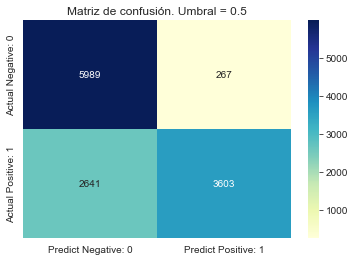

In [136]:
conf_mat(y_test, y_pred)

In [163]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.96      0.80      6256
           1       0.93      0.58      0.71      6244

    accuracy                           0.77     12500
   macro avg       0.81      0.77      0.76     12500
weighted avg       0.81      0.77      0.76     12500



<a id="section_MultinomialNB_2"></a>

### 2.4 - MultinomialNB con otro subreddit

[volver a TOC](#section_toc)

Vamos a probar el primer modelo pero usando otro subreddit como clase 1 para ver si el mismo modelo performa igual con otra clase

In [188]:
data_sample = binary_sample(data, 'subreddit', 'politics', random_state=42)
data_sample['class'] = 0
mask = data_sample['subreddit'] == 'politics'
data_sample.loc[mask, 'class'] = 1

In [189]:
X = data_sample["body"]
y = data_sample["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500,)
(12500,)
(37500,)
(12500,)


In [180]:
folds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

param_grid_4 = {'preprocesamiento' : [TfidfVectorizer(), CountVectorizer()],
                'preprocesamiento__stop_words': ['None', 'english'],  #con o sin stopwords
                'preprocesamiento__max_df': np.logspace(-2, 0, num= 10),  #elimina términos con frecuencia mayor al valor dado
                'preprocesamiento__min_df': np.logspace(-12, -10, num= 10), #elimina términos con frecuencia menor al valor dado
                'preprocesamiento__ngram_range': [(1,1),(1,2)], #genera n-gramas
                }

grid_4 = GridSearchCV(pipe_1, param_grid_4, cv= folds, verbose= 10, scoring= 'accuracy', n_jobs= -1)

El espacio de hiperparámetros es el mismo que cuando corrimos `MultinomialNB`, esperamos que llegue a los mismos y que tenga una performance similar.

In [190]:
# Aprox 35' sobre 2400 fits (3 folds, 800 combinaciones de hiperparámetros)
grid_4.fit(X_train, y_train)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1346s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (4.9588s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  1.8min
[Parallel(n_jo

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'preprocesamiento': [TfidfVectorizer(max_df=0.01,
                                                              min_df=1e-12,
                                                              stop_words='english'),
                                              CountVectorizer(max_df=0.1291549665014884,
                                                              min_df=1e-12,
                                                              ngram_range=(1,
                                                                           2),
                                                              stop_wor...
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ]),
                         'preprocesamiento__min_df':

In [191]:
modelo4_filename = 'multinomialNB_25k_2.pickle'
pickle.dump(grid_4, open(modelo4_filename, 'wb'))

In [192]:
grid_4 = pickle.load(open('multinomialNB_25k_2.pickle', 'rb'))

In [193]:
print(grid_4.best_params_)
print(grid_4.best_score_)

{'preprocesamiento': CountVectorizer(max_df=0.1291549665014884, min_df=1e-12, ngram_range=(1, 2),
                stop_words='english'), 'preprocesamiento__max_df': 0.1291549665014884, 'preprocesamiento__min_df': 1e-12, 'preprocesamiento__ngram_range': (1, 2), 'preprocesamiento__stop_words': 'english'}
0.8281333333333333


In [194]:
y_pred = grid_4.predict(X_test)
accuracy_score(y_test, y_pred)

0.83616

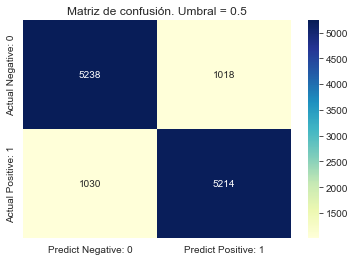

In [195]:
conf_mat(y_test, y_pred)

In [196]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6256
           1       0.84      0.84      0.84      6244

    accuracy                           0.84     12500
   macro avg       0.84      0.84      0.84     12500
weighted avg       0.84      0.84      0.84     12500

